In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [3]:
from __future__ import print_function, division

In [4]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
import seaborn
sns.set(font_scale=1.0)

In [5]:
import numpy
import pandas
import itertools
import functools
import copy
import Bio
import Bio.Alphabet.IUPAC as IUPAC
import toolz.dicttoolz as dicttoolz

In [6]:
import jug

/Users/grocklin/anaconda/lib/python2.7/site-packages/jug/backends/encoders/h5py_encoder.py:10: UserWarning: h5py imported, but h5py.h5p.PropFAID.set_file_image not supported. Ensure h5py > 2.6 and hdf > 1.8.9.
  warnings.warn("h5py imported, but h5py.h5p.PropFAID.set_file_image not supported. Ensure h5py > 2.6 and hdf > 1.8.9.")


In [41]:
from scipy.cluster.hierarchy import ward, complete, dendrogram
from scipy.spatial.distance import pdist
from matplotlib import gridspec
#sns.set_style('white')
def cluster_heatmap(fit_coeffs_,title=''):
    sns.set_style('white')
    sns.set(font_scale=2.2)
    coeffs=copy.deepcopy(fit_coeffs_["weights"][:,0:20])
    for i in range(len(coeffs)):
        coeffs[i,:] = coeffs[i,:] - np.average(coeffs[i,:])
    
    #coeffs[m.flanking_window] = fit_coeffs_["seq_weights"]
    #coeffs=np.exp(coeffs)
    labels=IUPAC.IUPACProtein.letters# + 'Z'
    dmat = pdist(coeffs.T)
    clusters = complete(dmat)

    plt.figure()
    plt.suptitle(title)
    #seaborn.heatmap(coeffs, xticklabels=labels)
    
    gs = gridspec.GridSpec(5, 1,
                       height_ratios=[0.2,0.03,1,0.04,0.13]
                       )
    ax1=plt.subplot(gs[0])
    dendro = dendrogram(clusters,labels=labels,
                        leaf_font_size=24,leaf_rotation=0,
                        link_color_func = lambda x: 'black')
    plt.yticks([])
    ax1.set_axis_bgcolor('white')
    for t in ['left','right','top','bottom']:
        ax1.spines[t].set_visible(False)
    ax2=plt.subplot(gs[2])
    coeffs=coeffs[:,dendro['leaves']]
    sns.heatmap(coeffs,xticklabels=[labels[t] for t in dendro['leaves']],cbar=False,
               yticklabels="P5 P4 P3 P2 P1 P1' P2' P3' P4'".split(),annot=True,fmt='.1f',annot_kws={"size": 9})
    ax3=plt.subplot(gs[4])
    p1coeffs=np.reshape(fit_coeffs_["seq_weights"][0:20],(1,20))[:,dendro['leaves']]
    p1coeffs = p1coeffs - np.average(p1coeffs)
    sns.heatmap(p1coeffs,cbar=False,xticklabels=['' for x in range(20)],
               yticklabels=["P1"],annot=True,fmt='.1f',annot_kws={"size": 9})
    plt.yticks(rotation=0) 

    
    #print dendro['leaves']
    #plt.tight_layout()
    
    
    
    #


In [8]:
import data_constk_161218_rd1234
full_data = data_constk_161218_rd1234.full_df
full_data["full_sequence"] = "GGGSASHM" + full_data["sequence"] + "LEGGGSEQ"
max_len=max([len(x) for x in full_data["full_sequence"].values])
full_data["full_sequence"] = [old_seq + ('Z' * (max_len - len(old_seq))) for old_seq in full_data["full_sequence"].values]


full_data_byprot = {
    t : full_data[full_data["protease"] == t]
    for t in ("chymo", "tryp")
    }

constk_scramble_data = data_constk_161218_rd1234.scramble_data

constk_scramble_data_no4=constk_scramble_data.query('round != 4')
constk_scramble_data = {
    t : constk_scramble_data[constk_scramble_data["protease"] == t].sample(frac=1,random_state=2)
    for t in ("chymo", "tryp")
}

rd1_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 1 8152 8152
rd2_merge_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 2 3923 3923
rd3_merge_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 3 4158 4158
rd4_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 4 5202 8692
rd1_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 1 8443 8443
rd2_merge_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 2 4244 4244
rd3_merge_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 3 4158 4158
rd4_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 4 5202 8676
114049
113982


In [9]:
full_data = data_constk_161218_rd1234.full_df
print (len(full_data))
full_data["full_sequence"] = "GGGSASHM" + full_data["sequence"] + "LEGGGSEQ"
max_len=max([len(x) for x in full_data["full_sequence"].values])
full_data["full_sequence"] = [old_seq + ('Z' * (max_len - len(old_seq))) for old_seq in full_data["full_sequence"].values]
full_data['hasC'] = ['C' in str(x) for x in full_data['sequence']]
full_data=full_data.query('hasC == False')
print (len(full_data))
full_data_byprot = {
    t : full_data[full_data["protease"] == t]#.query('ec50_95ci < 1')
    for t in ("chymo", "tryp")
}
print (len(full_data_byprot['tryp']))
print (len(full_data_byprot['chymo']))

def calc_data(protease, fit_coeffs_):
    temp_full_data=copy.deepcopy(full_data_byprot[protease].query('ec50_95ci < 1.0')[['name','round','ec50','full_sequence']])
    temp_full_data['ec50_pred'] = pred_data(list(temp_full_data['full_sequence']), fit_coeffs_)
    temp_full_data['ec50_rise'] = temp_full_data['ec50'] - temp_full_data['ec50_pred']
    return temp_full_data

113982
113982
56220
57762


In [10]:
thermo=pd.read_csv('thermodynamics.csv')
thermo['mutstring'] = ['+'.join(x.split()) for x in thermo['mutant']]
thermo['fullname'] = map(lambda x, y: '%s_%s' % (x,y), thermo['name'], thermo['mutstring'])
thermo_column=dict(
    villin= "deltaG chemical",
    BBL= "deltaG thermal",
    hYAP65 = "tm",
    pin1="deltaG thermal",
)

thermo_datasets={
    parent_protein : { protease: 
                         
                          pd.merge(left=thermo[['fullname',thermo_column[parent_protein]]],
                                   right=full_data_byprot[protease][np.array([parent_protein in x for x in full_data_byprot[protease]['name']])],
                                   left_on='fullname',
                                   right_on='name',
                                   how='inner')
                      
                      
                     for protease in ['tryp','chymo']
                     }
    for parent_protein in ['villin','pin1','BBL','hYAP65']
}



In [11]:
import protease_experimental_analysis.sequence_protease_susceptibility as sequence_protease_susceptibility
reload(sequence_protease_susceptibility)
from protease_experimental_analysis.sequence_protease_susceptibility import CenterLimitedPSSMModel
blank_model=CenterLimitedPSSMModel()
blank_model.setup()


In [20]:
def pred_data(full_sequence, fit_coeffs_):
    flanking_window = int((len(fit_coeffs_['weights'])-1) / 2)
    blank_model=CenterLimitedPSSMModel(flanking_window=flanking_window)
    blank_model.setup()
    blank_model.fit_coeffs_=copy.deepcopy(fit_coeffs_)
    return blank_model.predict(full_sequence)

def pred_data_pdb(full_sequence, fit_coeffs_):
    flanking_window = int((len(fit_coeffs_['weights'])-1) / 2)
    blank_model=CenterLimitedPSSMModel(flanking_window=flanking_window)
    blank_model.setup()
    blank_model.fit_coeffs_=copy.deepcopy(fit_coeffs_)
    return blank_model.predict(['GGGSASHM' + x+ 'LEGGGSEQ' for x in full_sequence])

def calc_thermo_R2(protein, protease, fit_coeffs_):
    flanking_window = int((len(fit_coeffs_['weights'])-1) / 2)
    blank_model=CenterLimitedPSSMModel(flanking_window=flanking_window)
    blank_model.setup()
    blank_model.fit_coeffs_=copy.deepcopy(fit_coeffs_)
    subdata=thermo_datasets[protein][protease]
    delta_ec50=subdata['ec50'].astype(float) - blank_model.predict(list(subdata['full_sequence']))
    return np.corrcoef(delta_ec50, subdata[thermo_column[protein]].astype(float))[0][1]**2.0

def calc_thermo_range(protein, protease, fit_coeffs_):
    flanking_window = int((len(fit_coeffs_['weights'])-1) / 2)
    blank_model=CenterLimitedPSSMModel(flanking_window=flanking_window)
    blank_model.setup()
    blank_model.fit_coeffs_=copy.deepcopy(fit_coeffs_)
    subdata=thermo_datasets[protein][protease]
    model_range= blank_model.predict(list(subdata['full_sequence']))
    return max(model_range) - min(model_range)

def plot_thermo_R2(protein, protease, fit_coeffs_):
    flanking_window = int((len(fit_coeffs_['weights'])-1) / 2)
    blank_model=CenterLimitedPSSMModel(flanking_window=flanking_window)
    blank_model.setup()
    blank_model.fit_coeffs_=copy.deepcopy(fit_coeffs_)
    subdata=thermo_datasets[protein][protease]
    delta_ec50=subdata['ec50'].astype(float) - blank_model.predict(list(subdata['full_sequence']))
    
    plt.scatter(delta_ec50, subdata[thermo_column[protein]].astype(float),6)
    
    
    fitline = np.polyfit(delta_ec50,subdata[thermo_column[protein]].astype(float),1)
    xdata_range=np.array([min(delta_ec50),max(delta_ec50)])
    plt.plot(xdata_range, np.polyval(fitline, xdata_range),linewidth=0.5,color='black')
    plt.title('%.3f' % np.corrcoef(delta_ec50, subdata[thermo_column[protein]].astype(float))[0][1]**2.0)

In [31]:
jug.init("sequence_protease_susceptibility_analysis.py")
import sequence_protease_susceptibility_analysis

In [32]:
NOLOAD = object()
def incremental_value(elem):
    if isinstance(elem, jug.task.TaskBase):
        return elem.value() if elem.can_load() else NOLOAD
    elif isinstance(elem, list):
        return [
            v for v in map(incremental_value, elem) if v is not NOLOAD
        ]
    elif isinstance(elem, tuple):
        rv = map(incremental_value, elem)
        assert all(v is not NOLOAD for v in rv)
        return rv
    elif isinstance(elem, dict):
        return {
            k : v for k, v in 
            zip(elem.keys(), map(incremental_value, elem.values()))
            if v is not NOLOAD
        }
    else:
        return elem

results = incremental_value( sequence_protease_susceptibility_analysis.model_results )
rmse = lambda v: numpy.sqrt( numpy.mean( numpy.square(v) ) )

In [33]:
rframe = pandas.DataFrame.from_records([
    dicttoolz.merge(
        p,
        dict(
            protease = d,
            rmsd = rmse(v.eval("ec50 - pred_ec50")),
            pred_ec50=v['pred_ec50'],
            ec50=v['ec50'],
            data=v,
            train_rmsd = rmse(v.eval("ec50 - fit_pred_ec50")),
            overfit = rmse(v.eval("ec50 - pred_ec50")) - rmse(v.eval("ec50 - fit_pred_ec50")),
            min_delta_vs_pred=extras['min_delta_vs_pred'],
            max_delta_vs_pred=extras['max_delta_vs_pred'],
            abs_max_delta_vs_pred=max([abs(extras['min_delta_vs_pred']), extras['max_delta_vs_pred']]),
            prottest_mse = extras['prottest_mse'],
            prottest_R2 = extras['prottest_R2'],
            prottest_slope = extras['prottest_slope'],
            correct_max_delta=max([abs(extras['min_delta_vs_pred']), extras['max_delta_vs_pred']]) * extras['prottest_slope'],
            cen_to_flank = extras['cen_to_flank'],
            fit_coeffs_=extras['fit_coeffs_'],
            BBL_R2=calc_thermo_R2('BBL',d,extras['fit_coeffs_']),
            pin1_R2=calc_thermo_R2('pin1',d,extras['fit_coeffs_']),
            hYAP65_R2=calc_thermo_R2('hYAP65',d,extras['fit_coeffs_']),
            villin_R2=calc_thermo_R2('villin',d,extras['fit_coeffs_']),
            BBL_range=calc_thermo_range('BBL',d,extras['fit_coeffs_']),
            pin1_range=calc_thermo_range('pin1',d,extras['fit_coeffs_']),
            hYAP65_range=calc_thermo_range('hYAP65',d,extras['fit_coeffs_']),
            villin_range=calc_thermo_range('villin',d,extras['fit_coeffs_']),
                
                
                
            #overall_R2=calc_data_R2(extras['fit_coeffs_']),
                
        ))
    for (d, p), (v,extras) in results.items()
])

rframe['log_alpha_flank'] = np.log(rframe['alpha_flank'])
rframe['log_alpha_center'] = np.log(rframe['alpha_center'])
rframe = rframe.sort_values(['protease','flanking_window','log_alpha_center','log_alpha_flank','error_upper_lim'])
rframe.index=range(len(rframe))
rframe['index'] = rframe.index

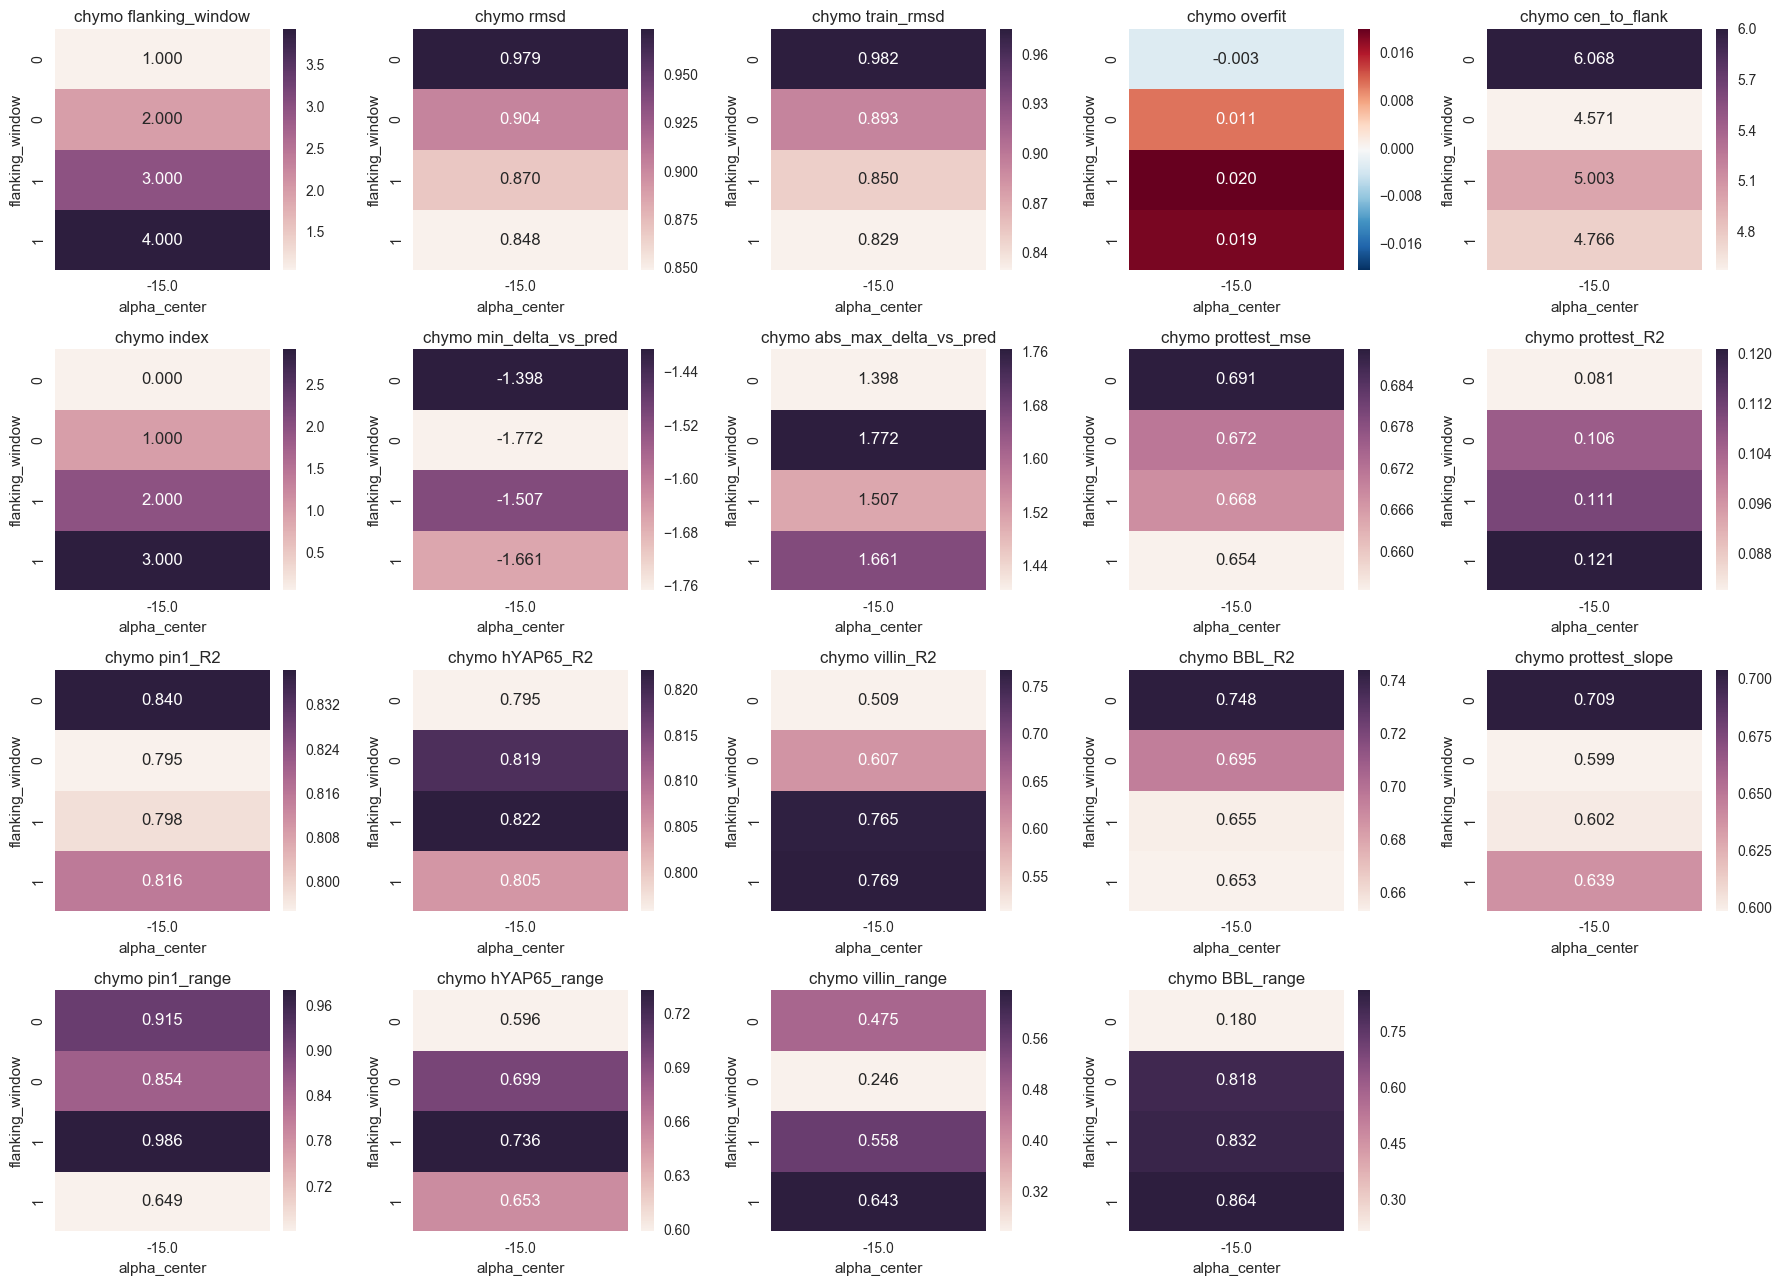

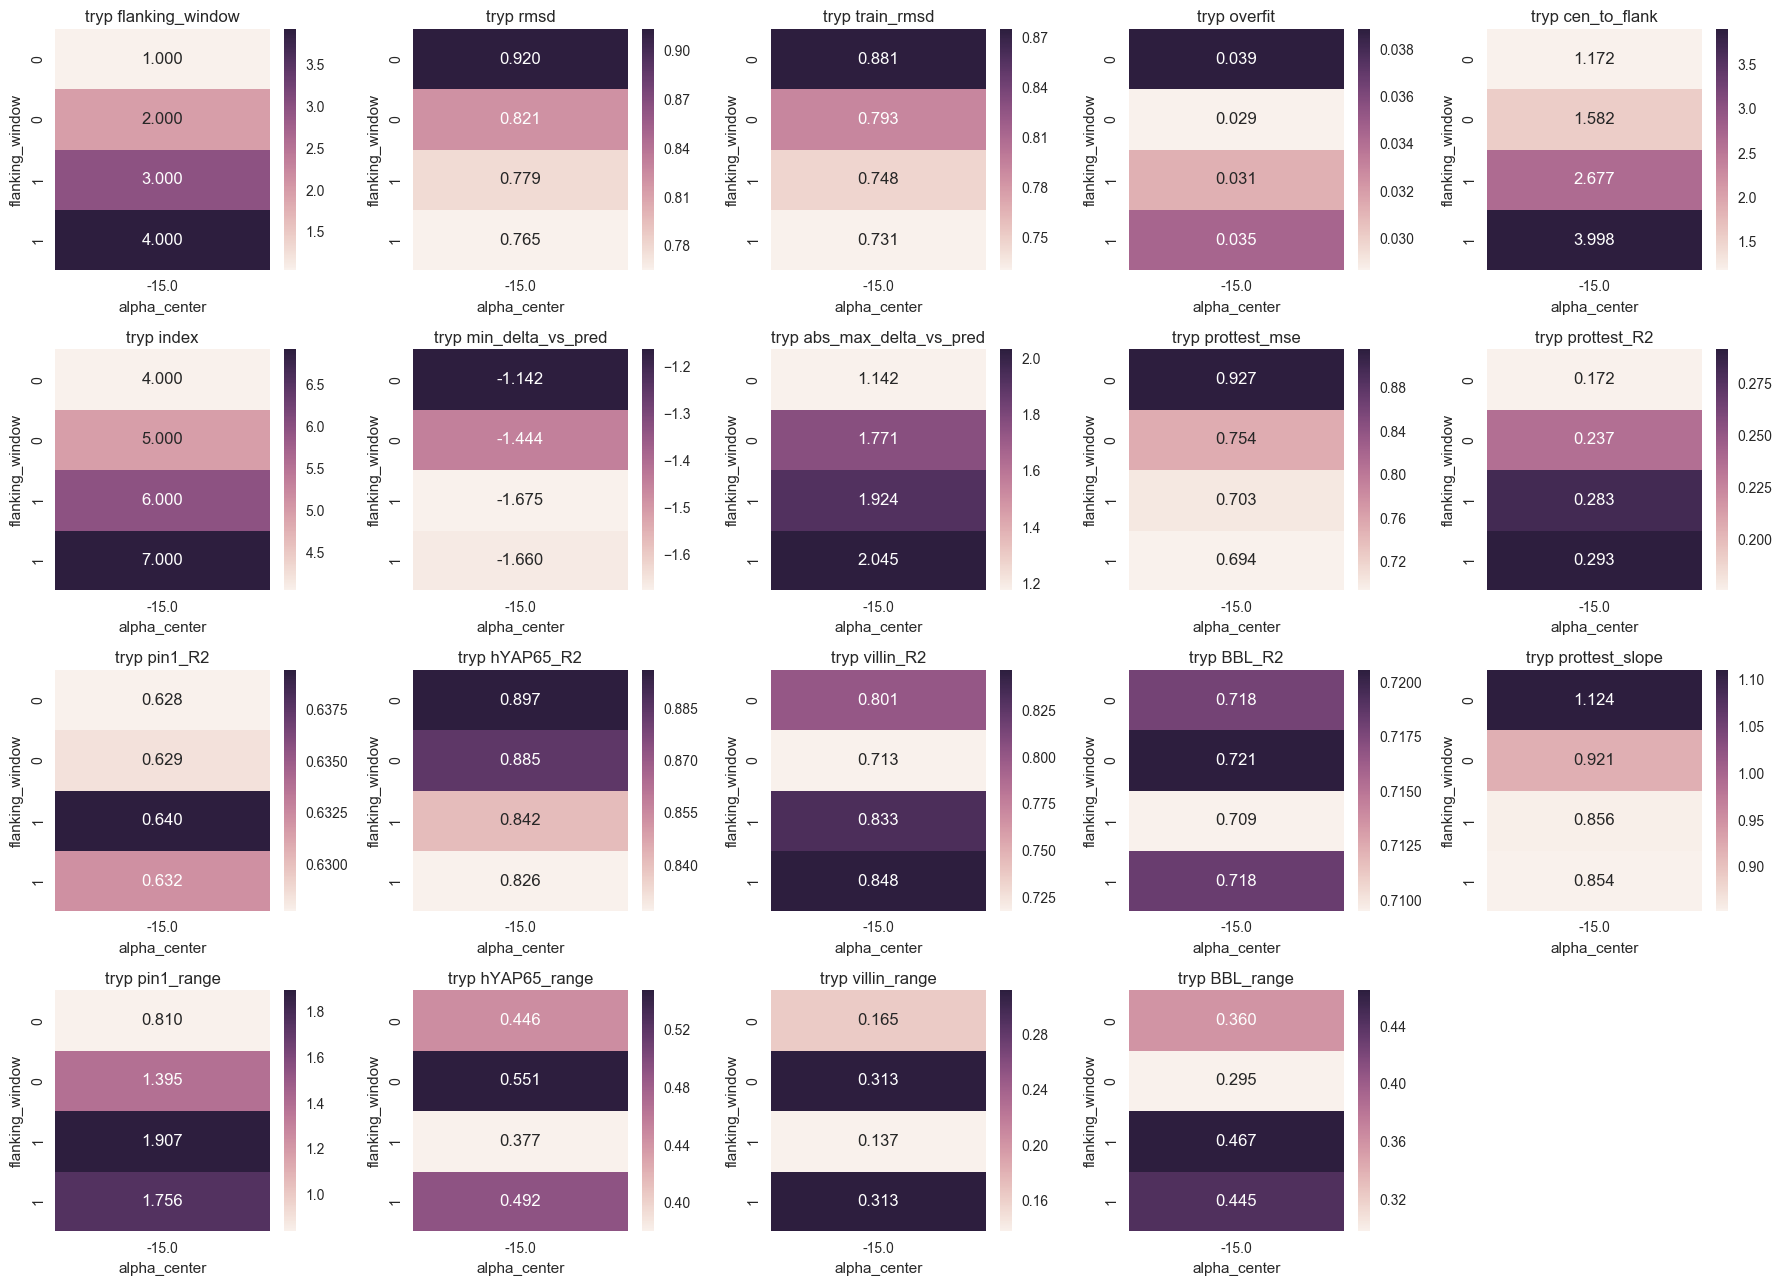

In [34]:
sns.set(font_scale=1.0)
for p in rframe.protease.unique():
    
    plt.figure(figsize=(18,13))
    for subplot_i, out in enumerate(['flanking_window','rmsd','train_rmsd','overfit','cen_to_flank',
                                     'index','min_delta_vs_pred','abs_max_delta_vs_pred','prottest_mse','prottest_R2',
                                    'pin1_R2','hYAP65_R2','villin_R2','BBL_R2','prottest_slope',
                                    'pin1_range','hYAP65_range','villin_range','BBL_range']):
    
        plt.subplot(4,5,subplot_i+1)

        tf = rframe[rframe.protease == p].pivot("flanking_window", "alpha_center", out)
        tf.columns.values[:] = numpy.log(tf.columns.values)
        tf.index.values[:] = numpy.log(tf.index.values)

        seaborn.heatmap(
            tf, annot=True, robust=True, fmt='.3f',annot_kws={"fontsize": 12}
        )
        pylab.title('%s %s' % (p,out))
    plt.tight_layout()


In [35]:
pred_df=[]
for j in range(0,8):
    pred_df.append(calc_data(rframe.ix[j, 'protease'], rframe.ix[j, 'fit_coeffs_']))

out=np.zeros((4,4))
pred_correl=np.zeros((4,4))
for i in range(4):
    for j in range(4):
        m=pd.merge(left=pred_df[i], right=pred_df[j+4],on=['name','round'],how='inner')
        out[i,j] = np.corrcoef(m['ec50_rise_x'],m['ec50_rise_y'])[0][1]**2.0        
        pred_correl[i,j] = np.corrcoef(m['ec50_pred_x'],m['ec50_pred_y'])[0][1]**2.0    



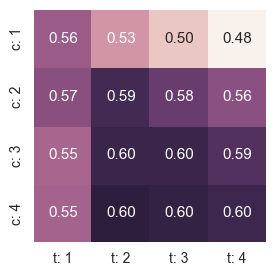

In [37]:
plt.figure(figsize=(3,3))

xlabels=['t: %s' % (x) for x in rframe['flanking_window'][4:]]
ylabels=['c: %s' % (x) for x in rframe['flanking_window'][0:4]]
sns.heatmap(out,annot=True,fmt='.2f',yticklabels=ylabels,xticklabels=xlabels,annot_kws={"fontsize": 11},cbar=False)

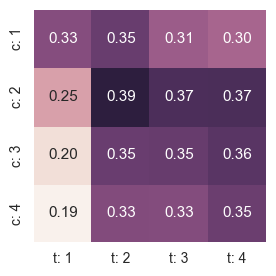

In [38]:
plt.figure(figsize=(3,3))

xlabels=['t: %s' % (x) for x in rframe['flanking_window'][4:]]
ylabels=['c: %s' % (x) for x in rframe['flanking_window'][0:4]]
sns.heatmap(pred_correl,annot=True,fmt='.2f',yticklabels=ylabels,xticklabels=xlabels,annot_kws={"fontsize": 11},cbar=False)

In [39]:
ssm_data = pandas.DataFrame.from_dict({
        "sequence" : map(str.strip, open('160924_grocklin_ssm2_myseqs').readlines())
    })

ssm_data["pred_sequence"] = ["GGGSASHM" + x + "LEGGGSEQ" + ('Z' * (46 - len(x))) for x in ssm_data.sequence.values]
#newbg=pd.read_csv('ssm_mut_pred_logistic_upweight10_161224',delim_whitespace=True)
bigtable_prot=pd.read_csv('big_ssm2_nextseq_table_known_frac_named',delim_whitespace=True,header=None)
bigtable_prot=bigtable_prot[[0,1]]
bigtable_prot.columns=['name','sequence']
ssm=pd.merge(left=bigtable_prot, right=ssm_data,on='sequence',how='inner')

ssm_lines="""EEHEE_rd3_0037.pdb   TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR
EEHEE_rd3_1498.pdb  GTLHLNGVTVKVPSLEKAIKAAKKFAKKYNLEVQVHGNTVHVH
EEHEE_rd3_1702.pdb  TTIHVGDLTLKYDNPKKAYEIAKKLAKKYNLTVTIKNGKITVT
EEHEE_rd3_1716.pdb  TEVHLGDIKLKYPNPEQAKKAAEKLAQKYNLTWTVIGDYVKIE
EHEE_0882.pdb       QETIEVEDEEEARRVAKELRKKGYEVKIERRGNKWHVHRT
EHEE_rd2_0005.pdb   TTRYRFTDEEEARRAAKEWARRGYQVHVTQNGTYWEVEVR
EHEE_rd3_0015.pdb   KTQYEYDTKEEAQKAYEKFKKQGIPVTITQKNGKWFVQVE
HEEH_rd2_0779.pdb   TLDEARELVERAKKEGTGVDVNGQRFEDWREAERWVREQEKNK
HEEH_rd3_0223.pdb   TIDEIIKALEQAVKDNKPIQVGNYTVTSADEAEKLAKKLKKEY
HEEH_rd3_0726.pdb   TELKKKLEEALKKGEEVRVKFNGIEIRITSEDAARKAVELLEK
HEEH_rd3_0872.pdb   TWQDLVKIAEKALEKGEPITINGITVTTKEQAKQAIEYLKKAY
HHH_0142.pdb        RKWEEIAERLREEFNINPEEAREAVEKAGGNEEEARRIVKKRL
HHH_rd2_0134.pdb    SKDEAQREAERAIRSGNKEEARRILEEAGYSPEQAERIIRKLG
HHH_rd3_0138.pdb    ERRKIEEIAKKLYQSGNPEAARRFLRKAGISEEEIERILQKAG
Pin1                MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG
hYAP65              FEIPDDVPLPAGWEMAKTSSGQRYFKNHIDQTTTWQDPRKAMLSQM
villin              LSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF
hYAP65_wt FEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKGGSNGNSNNS
villin_wt MLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLFGGNSGGSSSGSSGS
pin1_wt MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGNGSSG
BBL_H142W QNNDALSPAIRRLLAEWNLDASAIKGTGVGGRLTREDVEKHLAKAGGSGN""".split('\n')
wt_seqs={}
for line in ssm_lines:
    wt_seqs[line.split()[0]] = line.split()[1]

def wt(x):
    if '_wt' in x or x.split('_')[-1][-4:] in ['.pdb','AP65','llin','Pin1']:
        return x
    else:
        return '_'.join(x.split('_')[0:-1])
ssm['my_wt'] = ssm['name'].map(wt)

def delta_pred_vs_wt(wts, preds):
    wt_preds=dict(zip(wts, preds))
    return [wt_preds[wt] - pred for wt, pred in zip(wts, preds)]

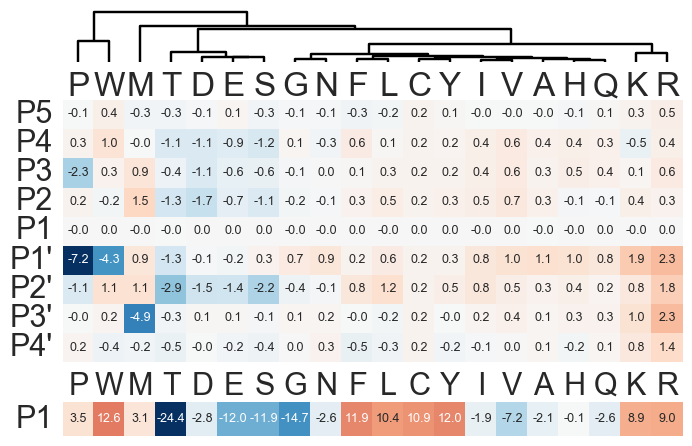

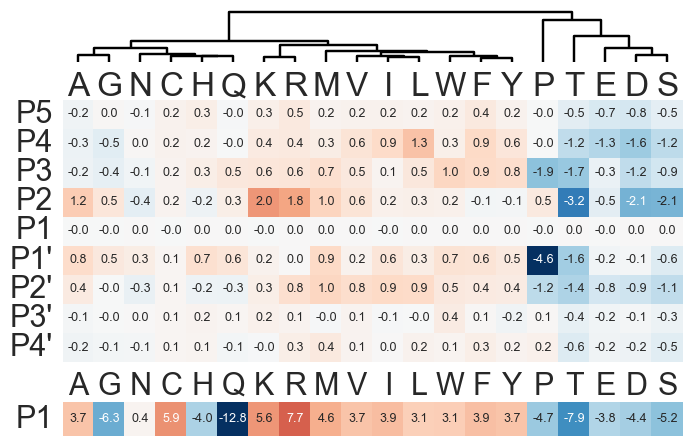

In [42]:
cluster_heatmap(rframe.ix[3, 'fit_coeffs_'])
cluster_heatmap(rframe.ix[7, 'fit_coeffs_'])

In [43]:
full_data = data_constk_161218_rd1234.full_df
full_data["full_sequence"] = "GGGSASHM" + full_data["sequence"] + "LEGGGSEQ"
max_len=max([len(x) for x in full_data["full_sequence"].values])
full_data["full_sequence"] = [old_seq + ('Z' * (max_len - len(old_seq))) for old_seq in full_data["full_sequence"].values]


full_data_byprot = {
    t : full_data[full_data["protease"] == t]
    for t in ("chymo", "tryp")
}

mod_number={'tryp': 7, 'chymo': 3}
for protease in ['tryp','chymo']:
    fit_coeffs_ = rframe.ix[mod_number[protease], 'fit_coeffs_']
    full_data_byprot[protease]['ec50_pred'] = pred_data(list(full_data_byprot[protease]['full_sequence']), fit_coeffs_)
    full_data_byprot[protease]['ec50_rise'] = full_data_byprot[protease]['ec50'] - full_data_byprot[protease]['ec50_pred']
    full_data_byprot[protease].to_csv('four_rds_modelpred_%s_170106.csv' % protease,index=False)
    
ssm_data = pandas.DataFrame.from_dict({
    "sequence" : map(str.strip, open('160924_grocklin_ssm2_myseqs').readlines())
})
ssm_data["pred_sequence"] = ["GGGSASHM" + x + "LEGGGSEQ" + ('Z' * (46 - len(x))) for x in ssm_data.sequence.values]

ssm_data['ec50_pred_t'] = pred_data(list(ssm_data["pred_sequence"]), rframe.ix[mod_number['tryp'], 'fit_coeffs_'])
ssm_data['ec50_pred_c'] = pred_data(list(ssm_data["pred_sequence"]), rframe.ix[mod_number['chymo'], 'fit_coeffs_'])
ssm_data.to_csv('ssm_mut_pred_logistic_170106',sep=' ',index=False)

/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
